In [1]:
# Libraries 

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from numpy.random import default_rng
#from random import random.seed,gauss

### LorenzConstLinQuadraticNVAR-Noise.py

standard deviation for x,y,z: 7.883122336535053 8.97825470486523 8.60827534371587
training nrmse: 0.0009529023054137471
test nrmse: 0.013474921182479772


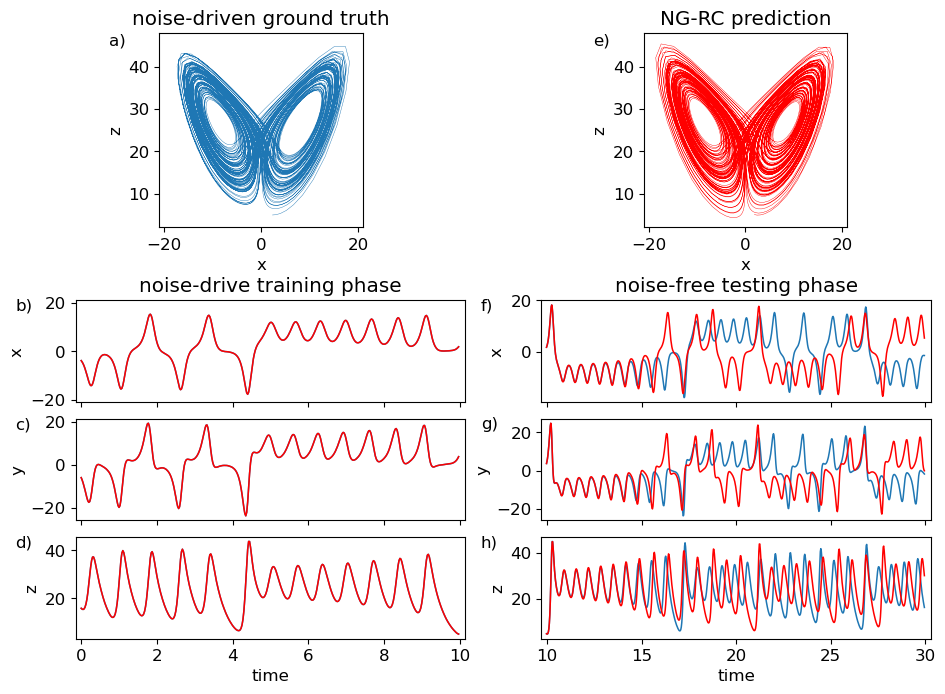

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 20 13:17:10 2021

NVAR with time delays for Lorenz forecasting.  Don't be efficient for now.

@author: Dan
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from numpy.random import default_rng
#from random import random.seed,gauss

##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=120.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 1.4e-2

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

# generate Gaussian random numbers at step dt and then interpolate for integrator
rng = np.random.default_rng(seed=1)

# width of the Gaussian distribution
width=1.

xran=rng.normal(0.,width,maxtime_pts+1)
yran=rng.normal(0.,width,maxtime_pts+1)
zran=rng.normal(0.,width,maxtime_pts+1)
xran_i = interp1d(t_eval,xran)
yran_i = interp1d(t_eval,yran)
zran_i = interp1d(t_eval,zran)

lorenz_soln_nf=np.zeros((d,maxtime_pts+1))

##
## Lorenz '63
##

sigma = 10
beta = 8 / 3
rho = 28

def lorenz(t, y):
  
  dy0 = sigma * (y[1] - y[0]) + xran_i(t)
  dy1 = y[0] * (rho - y[2]) - y[1] + yran_i(t)
  dy2 = y[0] * y[1] - beta * y[2] + zran_i(t)
  
  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]

# No noise derivative
def lorenz_nn(t, y):
  
  dy0 = sigma * (y[1] - y[0]) 
  dy1 = y[0] * (rho - y[2]) - y[1] 
  dy2 = y[0] * y[1] - beta * y[2] 
  
  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]

# I integrated out to t=50 to find points on the attractor, then use these as the initial conditions

lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')


# total variance of Lorenz solution
total_var=np.var(lorenz_soln.y[0,:])+np.var(lorenz_soln.y[1,:])+np.var(lorenz_soln.y[2,:])

print('standard deviation for x,y,z: '+str(np.std(lorenz_soln.y[0,:]))+' '+str(np.std(lorenz_soln.y[1,:]))+' '+str(np.std(lorenz_soln.y[2,:])))

##
## NVAR
##

# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

# create an array to hold the full feature vector for training time
# (use ones so the constant term is already 1)
out_train = np.ones((dtot,traintime_pts))

# copy over the linear part (shift over by one to account for constant)
out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

# fill in the non-linear part
cnt=0
for row in range(dlin):
    for column in range(row,dlin):
        # shift by one for constant
        out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
        cnt += 1

# ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))

# apply W_out to the training feature vector to get the training output
x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]

# calculate NRMSE between true Lorenz and training output
rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
print('training nrmse: '+str(rms))

# create a place to store feature vectors for prediction
out_test = np.zeros(dtot)              # full feature vector
x_test = np.zeros((dlin,testtime_pts)) # linear part

# copy over initial linear feature vector
x_test[:,0] = x[:,warmtrain_pts-1]

# do prediction
for j in range(testtime_pts-1):
    # copy linear part into whole feature vector
    out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
            cnt += 1
    # fill in the delay taps of the next state
    x_test[d:dlin,j+1]=x_test[0:(dlin-d),j]
    # do a prediction
    x_test[0:d,j+1] = x_test[0:d,j]+W_out @ out_test[:]

# no noise solution
t_eval_nn=np.linspace(0,testtime,testtime_pts+1)
lorenz_soln_nn = solve_ivp(lorenz, (0,testtime), x_test[0:d,0] , t_eval=t_eval_nn, method='RK23')

# calculate NRMSE between true Lorenz and prediction for one Lyapunov time
total_var_nn=np.var(lorenz_soln_nn.y[0,:])+np.var(lorenz_soln_nn.y[1,:])+np.var(lorenz_soln_nn.y[2,:])
test_nrmse = np.sqrt(np.mean((lorenz_soln_nn.y[0:d,0:lyaptime_pts]-x_test[0:d,0:lyaptime_pts])**2)/total_var_nn)
print('test nrmse: '+str(test_nrmse))

##
## Plot
##

t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30,35,40]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38) 
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true NOISY Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('noise-driven ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('noise-drive training phase') 
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(x_test[0,:],x_test[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('NG-RC prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('noise-free testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,lorenz_soln_nn.y[0,0:plottime_pts],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,lorenz_soln_nn.y[1,0:plottime_pts],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,lorenz_soln_nn.y[2,0:plottime_pts],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)

plt.savefig('predict-lorenz-noisy.png')
plt.savefig('predict-lorenz-noisy.svg')
plt.savefig('predict-lorenz-noisy.eps')
plt.savefig('predict-lorenz-noisy.pdf')


### LorenzConstLinQuadraticNVAR-NRMSE-vsTraintime.py

ridge regression parameter: 2.5e-06

test nrmse for traintime = 4.0 mean, meanerr: 0.01940356923933086 0.011386614057268134
test nrmse for traintime = 5.0 mean, meanerr: 0.012421203761700124 0.006737550319145207
test nrmse for traintime = 6.0 mean, meanerr: 0.004433796175794122 0.001875708829805232
test nrmse for traintime = 7.0 mean, meanerr: 0.0032908440724489646 0.0012855276459052074
test nrmse for traintime = 8.0 mean, meanerr: 0.004772002477369881 0.0017161319362566537
test nrmse for traintime = 9.0 mean, meanerr: 0.002509875950227097 0.0006446173389660197
test nrmse for traintime = 10.0 mean, meanerr: 0.0022324334840743516 0.0005165633731188024
test nrmse for traintime = 11.0 mean, meanerr: 0.004126908622339315 0.0013403990634879084
test nrmse for traintime = 12.0 mean, meanerr: 0.00572526011301418 0.0017816478813307635
test nrmse for traintime = 13.0 mean, meanerr: 0.002848243959393882 0.0004752908431656664
test nrmse for traintime = 14.0 mean, meanerr: 0.0042553804258692466 0.0

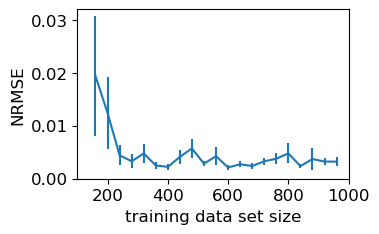

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 20 13:17:10 2021

NVAR with time delays for Lorenz forecasting, NRMSE and fixed points.
Don't be efficient for now.

May 18: fixed nrmse calculation, error of fixed points

@author: Dan
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

##
## Parameters
##

# number of NRMSE trials
npts=20
npts_train=21
# how far in to Lorenz solution to start
start=5.
start_train=4.
end_train=24.
step_train=(end_train-start_train)/(npts_train-1)

# time step
dt=0.025
    
# ridge parameter for regression
ridge_param = 2.5e-6

# create a vector of warmup and train times to use, dividing space into
# npts segments of length traintime
traintime_v=np.arange(start_train,end_train+step_train,step_train)

warmup_v=np.empty((npts_train,npts))
for i in range(npts_train):
    warmup_v[i,:]=np.arange(start,traintime_v[i]*npts+start,traintime_v[i])
    
testNRMSE=np.empty(npts_train)
testNRMSEerr=np.empty(npts_train)

# storage for results
test_nrmse_v=np.zeros(npts)

# run a trial with the given warmup time
def find_err(warmup,traintime):
    ##
    ## More Parameters
    ##

    # Lyapunov time of the Lorenz system
    lyaptime=1.104
    # units of time to test for
    testtime=lyaptime
    # total time to run for
    maxtime = warmup+traintime+testtime

    # discrete-time versions of the times defined above
    warmup_pts=round(warmup/dt)
    traintime_pts=round(traintime/dt)
    warmtrain_pts=warmup_pts+traintime_pts
    testtime_pts=round(testtime/dt)
    maxtime_pts=round(maxtime/dt)
    lyaptime_pts=round(lyaptime/dt)


    # input dimension
    d = 3
    # number of time delay taps
    k = 2
    # size of the linear part of the feature vector
    dlin = k*d
    # size of nonlinear part of feature vector
    dnonlin = int(dlin*(dlin+1)/2)
    # total size of feature vector: constant + linear + nonlinear
    dtot = 1 + dlin + dnonlin

    # t values for whole evaluation time
    # (need maxtime_pts + 1 to ensure a step of dt)
    t_eval=np.linspace(0,maxtime,maxtime_pts+1)

    ##
    ## Lorenz '63
    ##
    
    sigma = 10
    beta = 8 / 3
    rho = 28

    def lorenz(t, y):
      
      dy0 = sigma * (y[1] - y[0])
      dy1 = y[0] * (rho - y[2]) - y[1]
      dy2 = y[0] * y[1] - beta * y[2]
      
      # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
      return [dy0, dy1, dy2]
    
    # I integrated out to t=50 to find points on the attractor, then use these as the initial conditions
    
    lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

    # calculate mean, min, and max for all three components of Lorenz solution
    lorenz_stats=np.zeros((3,3))
    for i in range(3):
        lorenz_stats[0,i]=np.mean(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])
        lorenz_stats[1,i]=np.min(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])
        lorenz_stats[2,i]=np.max(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])

    # total variance of the Lorenz solution, corrected July 15, 2021, DJG
    total_var=np.var(lorenz_soln.y[0,:])+np.var(lorenz_soln.y[1,:])+np.var(lorenz_soln.y[2,:])

    ##
    ## NVAR
    ##

    # create an array to hold the linear part of the feature vector
    x = np.zeros((dlin,maxtime_pts))

    # fill in the linear part of the feature vector for all times
    for delay in range(k):
        for j in range(delay,maxtime_pts):
            x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

    # create an array to hold the full feature vector for training time
    # (use ones so the constant term is already 1)
    out_train = np.ones((dtot,traintime_pts))

    # copy over the linear part (shift over by one to account for constant)
    out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
            cnt += 1
    
    # ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
    W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))

    # apply W_out to the training feature vector to get the training output
    x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]
    
    # calculate NRMSE between true Lorenz and training output
    train_nrmse = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)

    # create a place to store feature vectors for prediction
    out_test = np.ones(dtot)               # full feature vector
    x_test = np.zeros((dlin,testtime_pts)) # linear part

    # copy over initial linear feature vector
    x_test[:,0] = x[:,warmtrain_pts-1]

    # do prediction
    for j in range(testtime_pts-1):
        # copy linear part into whole feature vector
        out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
        # fill in the non-linear part
        cnt=0
        for row in range(dlin):
            for column in range(row,dlin):
                # shift by one for constant
                out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
                cnt += 1
        # fill in the delay taps of the next state
        x_test[d:dlin,j+1] = x_test[0:(dlin-d),j]
        # do a prediction
        x_test[0:d,j+1] = x_test[0:d,j] + W_out @ out_test[:]

    # calculate NRMSE between true Lorenz and prediction for one Lyapunov time
    test_nrmse = np.sqrt(np.mean((x[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1]-x_test[0:d,0:lyaptime_pts])**2)/total_var)
    
    # return our findings
    return test_nrmse 

print('ridge regression parameter: '+str(ridge_param)+'\n')
# run many trials and collect the results
for j in range(npts_train):
    for i in range(npts):
        test_nrmse_v[i]=find_err(warmup_v[j,i],traintime_v[j])
        
    testNRMSE[j]=np.mean(test_nrmse_v)
    testNRMSEerr[j]=np.std(test_nrmse_v)/np.sqrt(npts)
    # output summaries
   
    print('test nrmse for traintime = '+str(traintime_v[j])+' mean, meanerr: '+str(testNRMSE[j])+' '+str(testNRMSEerr[j]))

plt.figure(figsize=(3.5,2.2))
plt.errorbar(traintime_v/dt,testNRMSE,yerr=testNRMSEerr)
plt.xlabel('training data set size')
plt.xlim(100.,1000.)
plt.xticks([200,400,600,800,1000])
plt.ylabel('NRMSE')
plt.ylim(0.,0.032)
plt.savefig('NRMSEvsTrainingPoints.png',bbox_inches="tight")
plt.savefig('NRMSEvsTrainingPoints.svg',bbox_inches="tight")
plt.savefig('NRMSEvsTrainingPoints.eps',bbox_inches="tight")
plt.savefig('NRMSEvsTrainingPoints.pdf',bbox_inches="tight")
plt.show()


### LorenzConstLinQuadraticNVARtimedelay-RK23.py

training nrmse: 0.00010249876029154128
test nrmse: 0.0006867152633257046


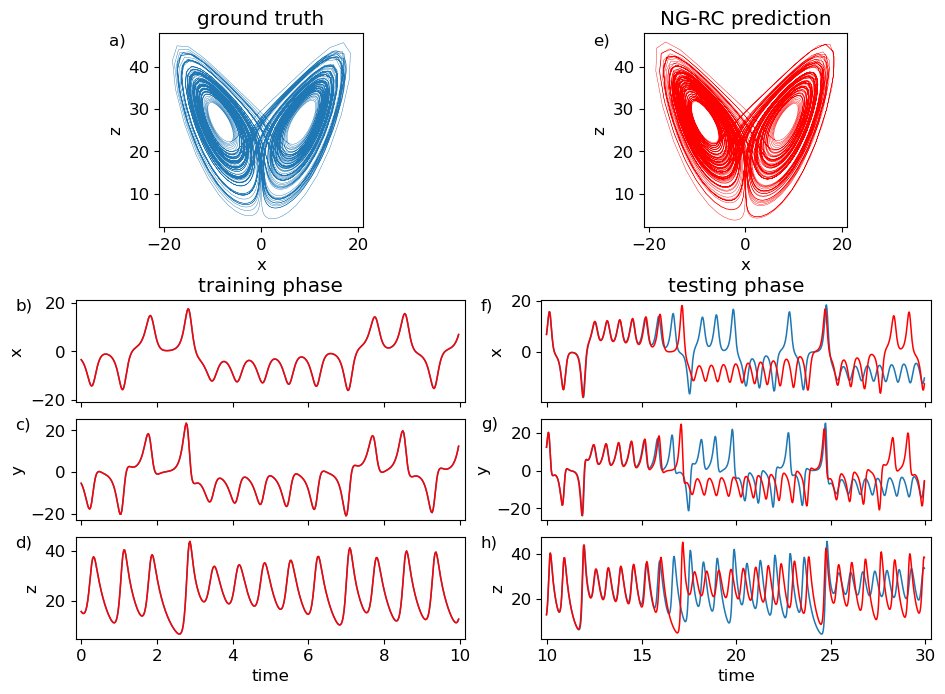

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=120.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 2.5e-6

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

##
## Lorenz '63
##

sigma = 10
beta = 8 / 3
rho = 28

def lorenz(t, y):
  
  dy0 = sigma * (y[1] - y[0])
  dy1 = y[0] * (rho - y[2]) - y[1]
  dy2 = y[0] * y[1] - beta * y[2]
  
  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]

# I integrated out to t=50 to find points on the attractor, then use these as the initial conditions

lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

# total variance of Lorenz solution
total_var=np.var(lorenz_soln.y[0:d,:])

##
## NVAR
##

# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

# create an array to hold the full feature vector for training time
# (use ones so the constant term is already 1)
out_train = np.ones((dtot,traintime_pts))

# copy over the linear part (shift over by one to account for constant)
out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

# fill in the non-linear part
cnt=0
for row in range(dlin):
    for column in range(row,dlin):
        # shift by one for constant
        out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
        cnt += 1

# ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))

# apply W_out to the training feature vector to get the training output
x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]

# calculate NRMSE between true Lorenz and training output
rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
print('training nrmse: '+str(rms))

# create a place to store feature vectors for prediction
out_test = np.zeros(dtot)              # full feature vector
x_test = np.zeros((dlin,testtime_pts)) # linear part

# copy over initial linear feature vector
x_test[:,0] = x[:,warmtrain_pts-1]

# do prediction
for j in range(testtime_pts-1):
    # copy linear part into whole feature vector
    out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
            cnt += 1
    # fill in the delay taps of the next state
    x_test[d:dlin,j+1]=x_test[0:(dlin-d),j]
    # do a prediction
    x_test[0:d,j+1] = x_test[0:d,j]+W_out @ out_test[:]

# calculate NRMSE between true Lorenz and prediction for one Lyapunov time
test_nrmse = np.sqrt(np.mean((x[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1]-x_test[0:d,0:lyaptime_pts])**2)/total_var)
print('test nrmse: '+str(test_nrmse))

##
## Plot
##

t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38) 
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('training phase') 
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(x_test[0,:],x_test[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('NG-RC prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[0,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[1,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[2,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)

plt.savefig('predict-lorenz.png')
plt.savefig('predict-lorenz.svg')
plt.savefig('predict-lorenz.eps')
plt.savefig('predict-lorenz.pdf')


### LorenzConstLinQuadraticNVARtimedelayNRMSE-RK23.py

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 20 13:17:10 2021

NVAR with time delays for Lorenz forecasting, NRMSE and fixed points.
Don't be efficient for now.

May 18: fixed nrmse calculation, error of fixed points

@author: Dan
"""

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

##
## Parameters
##

# number of NRMSE trials
npts=10
# how far in to Lorenz solution to start
start=5.
# units of time to train for
traintime=10.
# ridge parameter for regression
ridge_param = 2.5e-6

# create a vector of warmup times to use, dividing space into
# npts segments of length traintime
warmup_v=np.arange(start,traintime*npts+start,traintime)

# storage for results
train_nrmse_v=np.zeros(npts)
test_nrmse_v=np.zeros(npts)
n_fp1_diff_v=np.zeros(npts)
n_fp2_diff_v=np.zeros(npts)
n_fp0_diff_v=np.zeros(npts)
p_fp1_norm_v=np.zeros((npts, 3))
p_fp2_norm_v=np.zeros((npts, 3))
p_fp0_norm_v=np.zeros((npts, 3))

# run a trial with the given warmup time
def find_err(warmup):
    ##
    ## More Parameters
    ##

    # time step
    dt=0.025
    # Lyapunov time of the Lorenz system
    lyaptime=1.104
    # units of time to test for
    testtime=lyaptime
    # total time to run for
    maxtime = warmup+traintime+testtime

    # discrete-time versions of the times defined above
    warmup_pts=round(warmup/dt)
    traintime_pts=round(traintime/dt)
    warmtrain_pts=warmup_pts+traintime_pts
    testtime_pts=round(testtime/dt)
    maxtime_pts=round(maxtime/dt)
    lyaptime_pts=round(lyaptime/dt)


    # input dimension
    d = 3
    # number of time delay taps
    k = 2
    # size of the linear part of the feature vector
    dlin = k*d
    # size of nonlinear part of feature vector
    dnonlin = int(dlin*(dlin+1)/2)
    # total size of feature vector: constant + linear + nonlinear
    dtot = 1 + dlin + dnonlin

    # t values for whole evaluation time
    # (need maxtime_pts + 1 to ensure a step of dt)
    t_eval=np.linspace(0,maxtime,maxtime_pts+1)

    ##
    ## Lorenz '63
    ##
    
    sigma = 10
    beta = 8 / 3
    rho = 28

    def lorenz(t, y):
      
      dy0 = sigma * (y[1] - y[0])
      dy1 = y[0] * (rho - y[2]) - y[1]
      dy2 = y[0] * y[1] - beta * y[2]
      
      # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
      return [dy0, dy1, dy2]
    
    # I integrated out to t=50 to find points on the attractor, then use these as the initial conditions
    
    lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

    # calculate mean, min, and max for all three components of Lorenz solution
    lorenz_stats=np.zeros((3,3))
    for i in range(3):
        lorenz_stats[0,i]=np.mean(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])
        lorenz_stats[1,i]=np.min(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])
        lorenz_stats[2,i]=np.max(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])

    # total variance of the Lorenz solution, corrected July 15, 2021, DJG
    total_var=np.var(lorenz_soln.y[0,:])+np.var(lorenz_soln.y[1,:])+np.var(lorenz_soln.y[2,:])

    ##
    ## NVAR
    ##

    # create an array to hold the linear part of the feature vector
    x = np.zeros((dlin,maxtime_pts))

    # fill in the linear part of the feature vector for all times
    for delay in range(k):
        for j in range(delay,maxtime_pts):
            x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

    # create an array to hold the full feature vector for training time
    # (use ones so the constant term is already 1)
    out_train = np.ones((dtot,traintime_pts))

    # copy over the linear part (shift over by one to account for constant)
    out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
            cnt += 1
    
    # ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
    W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))

    # apply W_out to the training feature vector to get the training output
    x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]
    
    # calculate NRMSE between true Lorenz and training output
    train_nrmse = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)

    # create a place to store feature vectors for prediction
    out_test = np.ones(dtot)               # full feature vector
    x_test = np.zeros((dlin,testtime_pts)) # linear part

    # copy over initial linear feature vector
    x_test[:,0] = x[:,warmtrain_pts-1]

    # do prediction
    for j in range(testtime_pts-1):
        # copy linear part into whole feature vector
        out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
        # fill in the non-linear part
        cnt=0
        for row in range(dlin):
            for column in range(row,dlin):
                # shift by one for constant
                out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
                cnt += 1
        # fill in the delay taps of the next state
        x_test[d:dlin,j+1] = x_test[0:(dlin-d),j]
        # do a prediction
        x_test[0:d,j+1] = x_test[0:d,j] + W_out @ out_test[:]

    # calculate NRMSE between true Lorenz and prediction for one Lyapunov time
    test_nrmse = np.sqrt(np.mean((x[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1]-x_test[0:d,0:lyaptime_pts])**2)/total_var)
    
    # setup variables for predicted and true fixed points
    t_fp0=np.zeros(d)
    t_fp1=np.zeros(d)
    t_fp2=np.zeros(d)
    # true fixed point 0 is 0
    # true fixed point 1 is at...
    t_fp1[0]=np.sqrt(beta*(rho-1))
    t_fp1[1]=np.sqrt(beta*(rho-1))
    t_fp1[2]=rho-1
    # true fixed point 2 is at...
    t_fp2[0]=-t_fp1[0]
    t_fp2[1]=-t_fp1[1]
    t_fp2[2]=t_fp1[2]

    # this function does a single step NVAR prediction for a trial fixed point
    # and returns the difference between the input and prediction
    # we can then solve func(p_fp) == 0 to find a fixed point p_fp
    def func(p_fp):
        # create a trial input feature vector
        out_vec=np.ones(dtot)
        # fill in the linear part
        for ii in range(k):
            # all past input is p_fp
            out_vec[1+ii*d:1+(ii+1)*d]=p_fp[0:d]
        # fill in the nonlinear part of the feature vector
        cnt=0
        for row in range(dlin):
            for column in range(row,dlin):
                out_vec[dlin+1+cnt]=out_vec[1+row]*out_vec[1+column]
                cnt += 1
        return W_out @ out_vec

    # solve for the first fixed point and calculate distances
    p_fp1 = fsolve(func, t_fp1)
    n_fp1_diff=np.sqrt(np.sum((t_fp1-p_fp1)**2)/total_var)
    p_fp1_norm = (t_fp1 - p_fp1) / np.sqrt(total_var)

    # solve for second fixed point
    p_fp2 = fsolve(func, t_fp2)
    n_fp2_diff=np.sqrt(np.sum((t_fp2-p_fp2)**2)/total_var)
    p_fp2_norm = (t_fp2 - p_fp2) / np.sqrt(total_var)

    # solve for 0 fixed point
    p_fp0=fsolve(func, t_fp0)
    n_fp0_diff=np.sqrt(np.sum((t_fp0-p_fp0)**2)/total_var)
    p_fp0_norm = (t_fp0 - p_fp0) / np.sqrt(total_var)

    # return our findings
    return train_nrmse,test_nrmse,n_fp1_diff,n_fp2_diff,n_fp0_diff,p_fp1_norm,p_fp2_norm,p_fp0_norm

# run many trials and collect the results
for i in range(npts):
    train_nrmse_v[i],test_nrmse_v[i],n_fp1_diff_v[i],n_fp2_diff_v[i],n_fp0_diff_v[i],p_fp1_norm_v[i],p_fp2_norm_v[i],p_fp0_norm_v[i]=find_err(warmup_v[i])

# output summaries
print('\n ridge regression parameter: '+str(ridge_param)+'\n')
print('mean, meanerr, train nrmse: '+str(np.mean(train_nrmse_v))+' '+str(np.std(train_nrmse_v)/np.sqrt(npts)))
print('mean, meanerr, test nrmse: '+str(np.mean(test_nrmse_v))+' '+str(np.std(test_nrmse_v)/np.sqrt(npts)))

# mean / err of (normalized L2 distance from true to predicted fixed point)
print()
print('mean, meanerr, fp1 nL2 distance: '+str(np.mean(n_fp1_diff_v))+' '+str(np.std(n_fp1_diff_v)/np.sqrt(npts)))
print('mean, meanerr, fp2 nL2 distance: '+str(np.mean(n_fp2_diff_v))+' '+str(np.std(n_fp2_diff_v)/np.sqrt(npts)))
print('mean, meanerr, fp0 nL2 distance: '+str(np.mean(n_fp0_diff_v))+' '+str(np.std(n_fp0_diff_v)/np.sqrt(npts)))

# mean / err of (normalized difference between true and predicted fixed point)
print()
print('mean, meanerr, fp1', np.mean(p_fp1_norm_v, axis=0), np.std(p_fp1_norm_v, axis=0) / np.sqrt(npts))
print('mean, meanerr, fp2', np.mean(p_fp2_norm_v, axis=0), np.std(p_fp2_norm_v, axis=0) / np.sqrt(npts))
print('mean, meanerr, fp0', np.mean(p_fp0_norm_v, axis=0), np.std(p_fp0_norm_v, axis=0) / np.sqrt(npts))

# normalized L2 distance between true and (mean of predicted fixed point)
print()
print('nL2 distance to mean, meanerr, fp1', np.sqrt(np.sum(np.mean(p_fp1_norm_v, axis=0) ** 2)), np.sqrt(np.sum(np.var(p_fp1_norm_v, axis=0)) / npts))
print('nL2 distance to mean, meanerr, fp2', np.sqrt(np.sum(np.mean(p_fp2_norm_v, axis=0) ** 2)), np.sqrt(np.sum(np.var(p_fp2_norm_v, axis=0)) / npts))
print('nL2 distance to mean, meanerr, fp0', np.sqrt(np.sum(np.mean(p_fp0_norm_v, axis=0) ** 2)), np.sqrt(np.sum(np.var(p_fp0_norm_v, axis=0)) / npts))



 ridge regression parameter: 2.5e-06

mean, meanerr, train nrmse: 0.00010613537630044104 1.3996184671679286e-06
mean, meanerr, test nrmse: 0.001991978271521347 0.00043360412751847064

mean, meanerr, fp1 nL2 distance: 0.001271971048739142 0.00029439643829233487
mean, meanerr, fp2 nL2 distance: 0.0008331747645432397 9.81059648634535e-05
mean, meanerr, fp0 nL2 distance: 0.0036879818075035544 0.0009223097251379888

mean, meanerr, fp1 [0.0008209  0.00031369 0.00082897] [0.00014983 0.00019043 0.00020929]
mean, meanerr, fp2 [-6.14487865e-04  1.92083872e-06  4.49412731e-04] [4.37819769e-05 1.02868302e-04 9.26658900e-05]
mean, meanerr, fp0 [0.00017827 0.00102221 0.00056067] [9.66761864e-05 5.54089534e-04 1.32488162e-03]

nL2 distance to mean, meanerr, fp1 0.0012080818771618668 0.0003201782559287465
nL2 distance to mean, meanerr, fp2 0.0007612954941985905 0.00014520921534203632
nL2 distance to mean, meanerr, fp0 0.0011794210941781307 0.0014393306772915654


### LorenzConstLinQuadraticNVARtimedelayReturnMap-RK23.py

C:\Users\risho\anaconda3\envs\deep_learn\lib\site-packages\scipy\interpolate\_fitpack_impl.py:724: RuntimeWarning: The number of zeros exceeds mest
  warnings.warn(RuntimeWarning("The number of zeros exceeds mest"))


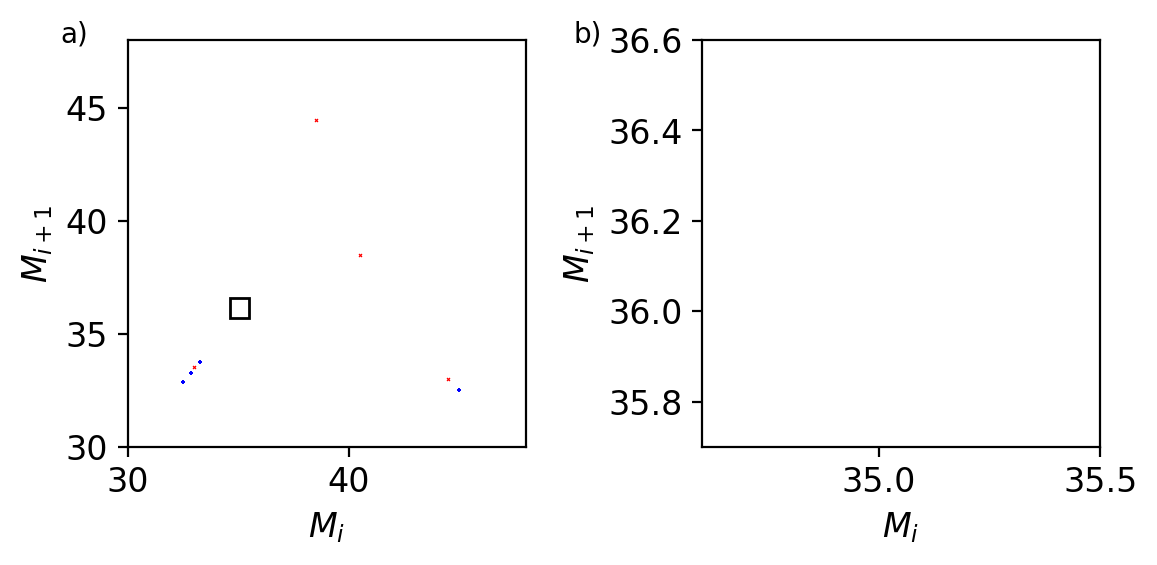

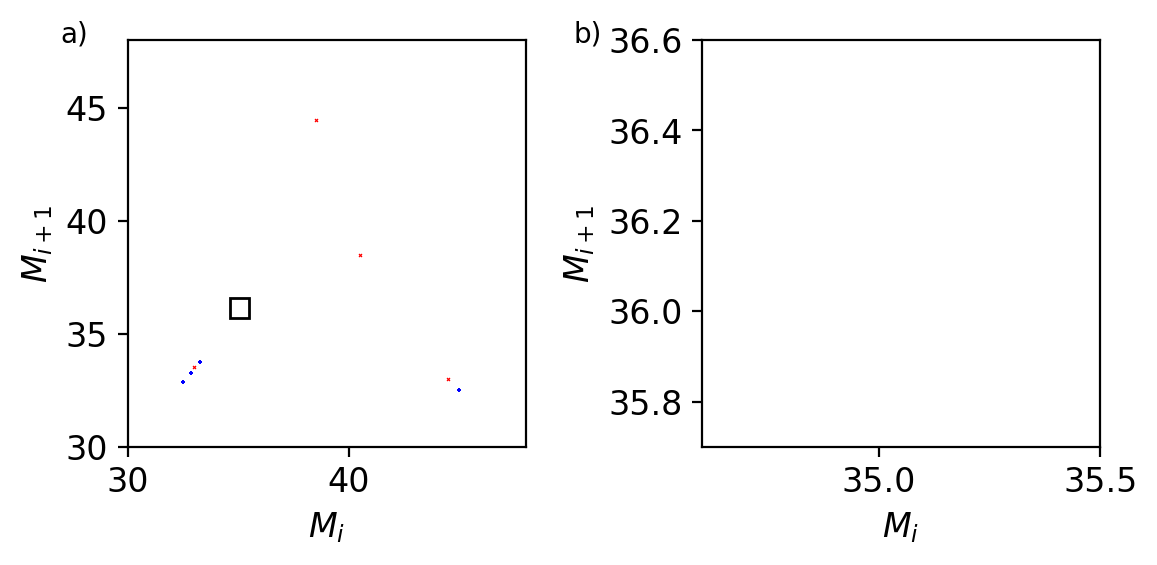

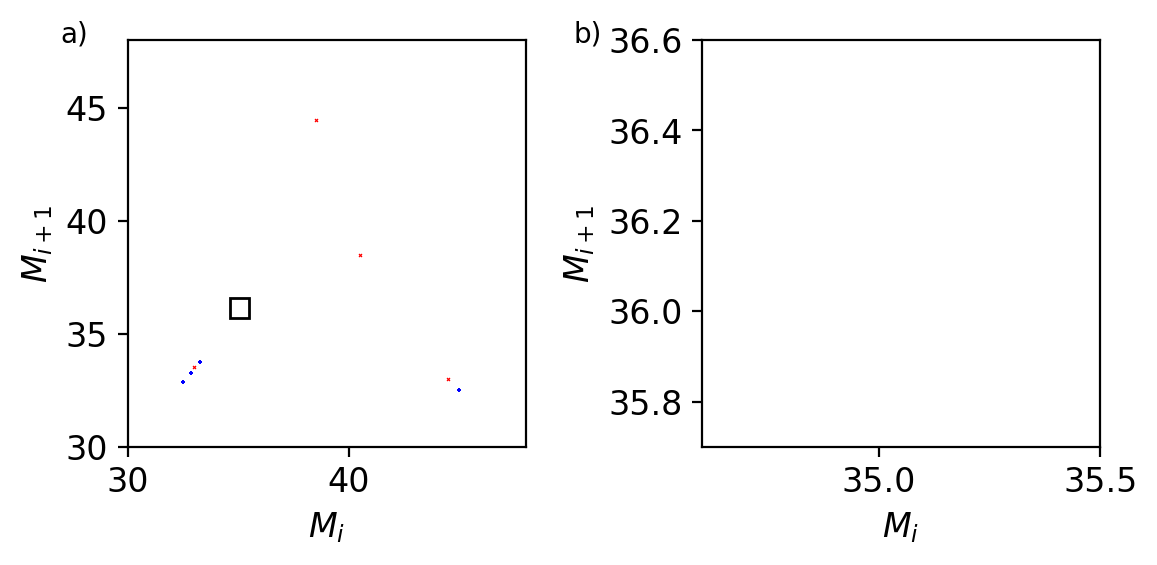

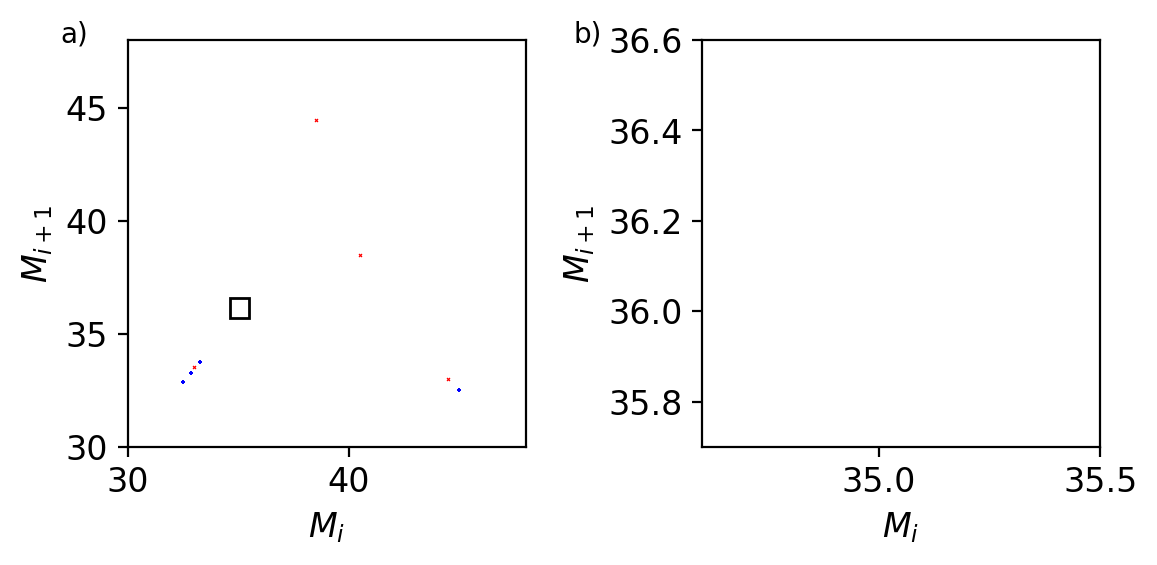

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 20 13:17:10 2021

NVAR with time delays.  Don't be efficient for now.

@author: Dan
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.signal
import scipy.interpolate
import matplotlib.patches

##
## Parameters
##

# how far in to Lorenz solution to start
start=5.
# units of time to train for
traintime=10.
# ridge parameter for regression
ridge_param = 2.5e-6

# run a trial with the given warmup time, and write a return map plot
# to the file in plotname
def find_err(warmup, plotname=None, lettera='a', letterb='b'):
    ##
    ## More Parameters
    ##

    # time step
    dt=0.025
    # units of time to test for
    testtime=1000.
    # total time to run for
    maxtime = warmup+traintime+testtime
    # Lyapunov time of the Lorenz system
    lyaptime=1.104

    # discrete-time versions of the times defined above
    warmup_pts=round(warmup/dt)
    traintime_pts=round(traintime/dt)
    warmtrain_pts=warmup_pts+traintime_pts
    testtime_pts=round(testtime/dt)
    maxtime_pts=round(maxtime/dt)
    lyaptime_pts=round(lyaptime/dt)


    # input dimension
    d = 3
    # number of time delay taps
    k = 2
    # size of the linear part of the feature vector
    dlin = k*d
    # size of the nonlinear part of the feature vector
    dnonlin = int(dlin*(dlin+1)/2)
    # total size of the feature vector: constant + linear + nonlinear
    dtot = 1 + dlin + dnonlin

    # t values for whole evaluation time
    # (need maxtime_pts + 1 to ensure a step of dt)
    t_eval=np.linspace(0,maxtime,maxtime_pts+1) # need the +1 here to have a step of dt

    ##
    ## Lorenz '63
    ##
    
    sigma = 10
    beta = 8 / 3
    rho = 28

    def lorenz(t, y):
      
      dy0 = sigma * (y[1] - y[0])
      dy1 = y[0] * (rho - y[2]) - y[1]
      dy2 = y[0] * y[1] - beta * y[2]
      
      # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
      return [dy0, dy1, dy2]
    
    # I integrated out to t=50 to find points on the attractor, then use these as the initial conditions
    
    lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

    # total variance of the Lorenz solution
    total_var=np.var(lorenz_soln.y[0:d,:])

    # calculate mean, min, and max for all three components of Lorenz solution
    lorenz_stats=np.zeros((3,3))
    for i in range(3):
        lorenz_stats[0,i]=np.mean(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])
        lorenz_stats[1,i]=np.min(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])
        lorenz_stats[2,i]=np.max(lorenz_soln.y[i,warmtrain_pts:maxtime_pts])

    ##
    ## NVAR
    ##

    # create an array to hold the linear part of the feature vector
    x = np.zeros((dlin,maxtime_pts))

    # fill in the linear part of the feature vector for all times
    for delay in range(k):
        for j in range(delay,maxtime_pts):
            x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

    # create an array to hold the full feature vector for training time
    # (use ones so the constant term is already 1)
    out_train = np.ones((dtot,traintime_pts))
    
    # copy over the linear part (shift over by one to account for constant)
    out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
            cnt += 1
    
    # ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
    W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))
    
    # apply W_out to the training feature vector to get the training output
    x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]
    
    # calculate NRMSE between true Lorenz and training output
    train_nrmse = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)

    # create a place to store feature vectors for prediction
    out_test = np.ones(dtot)               # full feature vector
    x_test = np.zeros((dlin,testtime_pts)) # linear part

    # copy over initial linear feature vector
    x_test[:,0] = x[:,warmtrain_pts-1]

    # do prediction
    for j in range(testtime_pts-1):
        # copy linear part into whole feature vector
        out_test[1:dlin+1]=x_test[:,j]
        # fill in the non-linear part
        cnt=0
        for row in range(dlin):
            for column in range(row,dlin):
                # shift by one for constant
                out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
                cnt += 1
        # fill in the delay taps of the next state
        x_test[d:dlin,j+1] = x_test[0:(dlin-d),j]
        # do a prediction
        x_test[0:d,j+1] = x_test[0:d,j] + W_out @ out_test[:]
    

    # calculate NRMSE between true Lorenz and prediction for one Lyapunov time
    test_nrmse = np.sqrt(np.mean((x[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1]-x_test[0:d,0:lyaptime_pts])**2)/total_var)

    # if requested, make a return plot
    if plotname:
        # get predicted return map
        rm = return_map_spline(x_test[2, :])
        # get true return map
        rm_cmp = return_map_spline(lorenz_soln.y[2,:testtime_pts])

        # plot
        fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200, figsize=(6, 3))

        # whole return map
        ax1.scatter(rm_cmp[:, 0], rm_cmp[:, 1], marker='P', s=2, label='Lorenz63', color='blue', linewidths=0)
        ax1.scatter(rm[:, 0], rm[:, 1], marker='X', s=2, label='NG-RC', color='red', linewidths=0)
        ax1.set_xlim(30, 48)
        ax1.set_ylim(30, 48)
        ax1.set_xlabel('$M_i$')
        ax1.set_ylabel('$M_{i+1}$')

        # zoomed return map
        ax2.scatter(rm_cmp[:, 0], rm_cmp[:, 1], marker='P', s=5, label='Lorenz63', color='blue', linewidths=0)
        ax2.scatter(rm[:, 0], rm[:, 1], marker='X', s=5, label='NG-RC', color='red', linewidths=0)
        xlim2 = (34.6, 35.5)
        ylim2 = (35.7, 36.6)
        ax2.set_xlim(*xlim2)
        ax2.set_ylim(*ylim2)
        ax2.set_xlabel('$M_i$')
        ax2.set_ylabel('$M_{i+1}$')

        # draw the zoomed rectangle on the whole
        rect = matplotlib.patches.Rectangle((xlim2[0], ylim2[0]), xlim2[1] - xlim2[0], ylim2[1] - ylim2[0], linewidth=1, edgecolor='k', facecolor='none')
        ax1.add_patch(rect)

        # subplot labels
        ax1.text(-0.1, 1.05, lettera + ')', transform=ax1.transAxes, fontsize=10, va='top', ha='right')
        ax2.text(-0.25, 1.05, letterb + ')', transform=ax2.transAxes, fontsize=10, va='top', ha='right')

        # write out
        plt.tight_layout()
        plt.savefig(plotname, dpi=600)    

# use interpolating splines to find maxima of input signal, and return an array
# of (M_i, M_i+1) pairs
def return_map_spline(v):
    spline = scipy.interpolate.InterpolatedUnivariateSpline(np.arange(len(v)), v, k=4)
    spline_d = spline.derivative()
    spline_dd = spline_d.derivative()

    # when is the derivative of v zero?
    extimes = spline_d.roots()

    # discard times out of bound
    extimes = extimes[extimes > 0]
    extimes = extimes[extimes < len(v) - 1]

    # select only local maxima
    extimes = extimes[spline_dd(extimes) < 0]

    # find values
    ex = spline(extimes)

    # construct return map
    return np.stack([ex[:-1], ex[1:]], axis=-1)

find_err(start, plotname='lorenz-rmap.png')
find_err(start, plotname='lorenz-rmap.svg')
find_err(start, plotname='lorenz-rmap.eps')
find_err(start, plotname='lorenz-rmap.pdf')
